Following https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html

In [1]:
from scipy import optimize, special
import numpy as np

In [2]:
def func(mu, theta):
    thetamu = theta * mu
    value = np.log(mu) + np.logaddexp(0, thetamu)
    return value

def jac(mu, theta):
    thetamu = theta * mu
    jac = theta * special.expit(thetamu) + 1 / mu
    return jac

def mu_from_theta(theta):
    return optimize.newton(func, 1, fprime=jac, args=(0.4,))

In [5]:
import sympy

mu = sympy.Function('mu')
theta = sympy.Symbol('theta')
R = mu(theta) + mu(theta) * sympy.exp(theta * mu(theta)) - 1
solution = sympy.solve(R.diff(theta), mu(theta).diff(theta))[0]
solution

-mu(theta)**2*exp(theta*mu(theta))/(theta*mu(theta)*exp(theta*mu(theta)) + exp(theta*mu(theta)) + 1)

In [9]:
import theano
import theano.tensor as tt
import theano.tests.unittest_tools

class MuFromTheta(tt.Op):
    itypes = [tt.dscalar]
    otypes = [tt.dscalar]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = mu_from_theta(theta)
        outputs[0][0] = np.array(mu)

    def grad(self, inputs, g):
        theta, = inputs
        mu = self(theta)
        thetamu = theta * mu
        return [- g[0] * mu ** 2 / (1 + thetamu + tt.exp(-thetamu))]

In [10]:
import pymc3 as pm

tt_mu_from_theta = MuFromTheta()

with pm.Model() as model:
    theta = pm.HalfNormal('theta', sigma=1)
    mu = pm.Deterministic('mu', tt_mu_from_theta(theta))
    pm.Normal('y', mu=mu, sigma=0.1, observed=[0.2, 0.21, 0.3])

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [04:14<00:00, 23.59draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument b

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc13e0af10>,
      dtype=object)

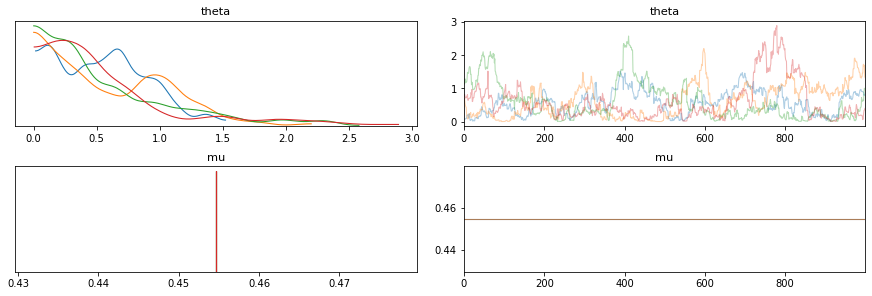

In [11]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc0384ad10>,
      dtype=object)

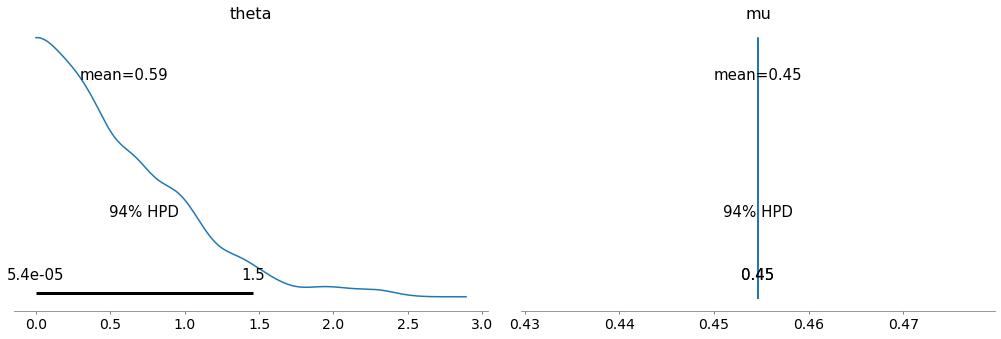

In [12]:
pm.plot_posterior(trace)

In [13]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.592,0.493,0.000,1.458,0.078,0.056,40.0,40.0,40.0,74.0,1.12
mu,0.455,0.000,0.455,0.455,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
